### **Evidencia Parte 3**

Integrantes del equipo 3:

Miranda Isabel Rada Chau A01285243

Eliani González Laguna A00836712

Pablo Pérez Sandoval A01710355

## Pre-procesamiento del mapa

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#  Pre-procesamiento del mapa de alturas
#------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------------------------------
#   Libreria
#------------------------------------------------------------------------------------------------------------------
import copy
import numpy as np
from skimage.transform import downscale_local_mean

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

import plotly.graph_objects as px

#------------------------------------------------------------------------------------------------------------------
#   Archivos
#------------------------------------------------------------------------------------------------------------------
input_file = "/content/crater_map.IMG"
output_file = "crater_map.npy"

#------------------------------------------------------------------------------------------------------------------
#  Cargar los datos del mapa
#------------------------------------------------------------------------------------------------------------------

data_file = open(input_file, "rb")

endHeader = False;
while not endHeader:
    line = data_file.readline().rstrip().lower()

    sep_line = line.split(b'=')

    if len(sep_line) == 2:
        itemName = sep_line[0].rstrip().lstrip()
        itemValue = sep_line[1].rstrip().lstrip()

        if itemName == b'valid_maximum':
            maxV = float(itemValue)
        elif itemName == b'valid_minimum':
            minV = float(itemValue)
        elif itemName == b'lines':
            n_rows = int(itemValue)
        elif itemName == b'line_samples':
            n_columns = int(itemValue)
        elif itemName == b'map_scale':
            scale_str = itemValue.split()
            if len(scale_str) > 1:
                scale = float(scale_str[0])

    elif line == b'end':
        endHeader = True
        char = 0
        while char == 0 or char == 32:
            char = data_file.read(1)[0]
        pos = data_file.seek(-1, 1)

image_size = n_rows*n_columns
data = data_file.read(4*image_size)

image_data = np.frombuffer(data, dtype=np.dtype('f'))
image_data = image_data.reshape((n_rows, n_columns))
image_data = np.array(image_data)
image_data = image_data.astype('float64')

image_data = image_data - minV;
image_data[image_data < -10000] = -1;

#------------------------------------------------------------------------------------------------------------------
#   Submuestreo
#------------------------------------------------------------------------------------------------------------------
sub_rate = round(10/scale)

image_data = downscale_local_mean(image_data, (sub_rate, sub_rate))
image_data[image_data<0] = -1

print('Sub-sampling:', sub_rate)

new_scale = scale*sub_rate
print('New scale:', new_scale, 'meters/pixel')



Sub-sampling: 10
New scale: 10.045020712681001 meters/pixel


## Guarda el mapa

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Guarda el mapa
#------------------------------------------------------------------------------------------------------------------
np.save(output_file, image_data)



## Muestreo

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Muestra la superficie 3D
#------------------------------------------------------------------------------------------------------------------

x = new_scale*np.arange(image_data.shape[1])
y = new_scale*np.arange(image_data.shape[0])
X, Y = np.meshgrid(x, y)

fig = px.Figure(data = px.Surface(x=X, y=Y, z=np.flipud(image_data), colorscale='hot', cmin = 0,
                           lighting = dict(ambient = 0.0, diffuse = 0.8, fresnel = 0.02, roughness = 0.4, specular = 0.2),
                           lightposition=dict(x=0, y=n_rows/2, z=2*maxV)),

                layout = px.Layout(scene_aspectmode='manual',
                                   scene_aspectratio=dict(x=1, y=n_rows/n_columns, z=max((maxV-minV)/x.max(), 0.2)),
                                   scene_zaxis_range = [0,maxV-minV])
                )

fig.show()



## Imagen de la superficie

<ipython-input-7-8a5b5459c09d>:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



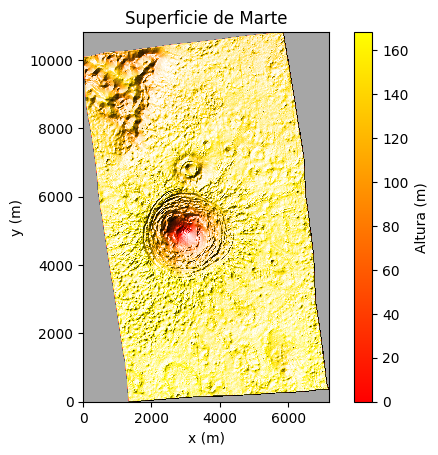

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Muestra la imagen de la superficie
#------------------------------------------------------------------------------------------------------------------

cmap = copy.copy(plt.cm.get_cmap('autumn'))
cmap.set_under(color='black')

ls = LightSource(315, 45)
rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')

fig, ax = plt.subplots()

im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(),
                extent =[0, scale*n_columns, 0, scale*n_rows],
                interpolation ='nearest', origin ='upper')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Altura (m)')

plt.title('Superficie de Marte')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()



##  Calculo de renglones y columnas

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Calcular el renglon r y columna c de una coordenada x y y y nombra la escala
#---------------------------------------------------------------------------------------------------------------------
import numpy as np
import time
import random
import math
crater_map = np.load('crater_map.npy')
nr, nc = crater_map.shape
escala = new_scale


El robot explorador que se desea enviar sólo es capaz de utilizar información de su alrededor para tomar decisiones. Es decir, sólo conocerá la profundidad en su vecindad. Por ello, los ingenieros decidieron que en la simulaciones, si el explorador se encuentra en cierto pixel de la imagen, sólo será capaz de conocer la profundidad en los ocho pixeles vecinos. Además, para evitar daños en el robot, no se permite que el explorador se mueva a pixeles con una diferencia de altura mayor a 2.0 metros de la posición en donde se encuentre.

Para llevar a cabo las simulaciones del descenso, como una primera aproximación, se desea probar algoritmos de búsqueda local tales como búsqueda codiciosa y recocido simulado como mecanismos de toma de decisiones del robot. Para ello, realicen lo siguiente.

## Cambio de coordenadas

In [ ]:
#Cambiar las coordenadas X Y a coordenadas en el mapa con renglones y columnas
def coordenadas_escala(pixel,escala,nr):
  r=nr-round(pixel[1]/escala)
  c=round(pixel[0]/escala)
  return  [r,c]


## Clase robot

In [ ]:
#Se crea la clase del Robot

class Robot(object):
    """
       Clase que escoge el pixel en el que se encuentra el explorador.
    """

    def __init__(self, punto_inicial):
        """
            Este constructor inicializa el robot en uno de los pixeles de la imagen.

            pixel: El pixel en el que inicia la imagen .
        """
        self.pixel = pixel
    def show(self):
      print("El pixel actual es:", self.pixel)
    def profundidad(self):
        """ Este metodo calcula la altura del pixel. """
        return crater_map[self.pixel[0]][self.pixel[1]]

    def cost(self):
        """ Este metodo calcula el costo del movimiento"""
        c = 0
        c = self.profundidad()*1
        return c

    def neighbor(self):
        """ Este método elige uno de los vecinos del pixel actual"""
        vecinos = []
        mejor_vecino =  Robot(self.pixel)
        vecino1 = Robot(self.pixel)
        vecino2 = Robot(self.pixel)
        vecino3 = Robot(self.pixel)
        vecino4 = Robot(self.pixel)
        vecino5 = Robot(self.pixel)
        vecino6 = Robot(self.pixel)
        vecino7 = Robot(self.pixel)
        vecino8 = Robot(self.pixel)
        vecino1.pixel = self.pixel.copy()
        vecino2.pixel = self.pixel.copy()
        vecino3.pixel = self.pixel.copy()
        vecino4.pixel = self.pixel.copy()
        vecino5.pixel = self.pixel.copy()
        vecino6.pixel = self.pixel.copy()
        vecino7.pixel = self.pixel.copy()
        vecino8.pixel = self.pixel.copy()
        #Se generan todos los vecinos del pixel actual.
        if vecino1.pixel[0]< nr:
          vecino1.pixel[0]+=1
          if (self.profundidad()-vecino1.profundidad()) < 2 and vecino1.profundidad() != -1:
            vecinos.append(vecino1.profundidad())
          else:
            vecinos.append(1000)
        if vecino2.pixel[0]< nr:
          vecino2.pixel[0]-=1
          if (self.profundidad()-vecino2.profundidad()) < 2 and vecino2.profundidad() != -1:
            vecinos.append(vecino2.profundidad())
          else:
            vecinos.append(1000)
        if vecino3.pixel[1]< nc:
          vecino3.pixel[1]+=1
          if (self.profundidad()-vecino3.profundidad()) < 2 and vecino3.profundidad() != -1:
            vecinos.append(vecino3.profundidad())
          else:
            vecinos.append(1000)
        if vecino4.pixel[1]< nc:
          vecino4.pixel[1]-=1
          if (self.profundidad()-vecino4.profundidad()) < 2 and vecino4.profundidad() != -1:
            vecinos.append(vecino4.profundidad())
          else:
            vecinos.append(1000)
        if vecino5.pixel[1]< nc and vecino5.pixel[0]< nr:
          vecino5.pixel[0]+=1
          vecino5.pixel[1]+=1
          if (self.profundidad()-vecino5.profundidad()) < 2 and vecino5.profundidad() != -1:
            vecinos.append(vecino5.profundidad())
          else:
            vecinos.append(1000)
        if vecino6.pixel[1]< nc and vecino6.pixel[0]< nr:
          vecino6.pixel[0]-=1
          vecino6.pixel[1]-=1
          if (self.profundidad()-vecino6.profundidad()) < 2 and vecino6.profundidad() != -1:
            vecinos.append(vecino6.profundidad())
          else:
            vecinos.append(1000)
        if vecino7.pixel[1]< nc and vecino7.pixel[0]< nr:
          vecino7.pixel[0]+=1
          vecino7.pixel[1]-=1
          if (self.profundidad()-vecino7.profundidad())< 2 and vecino7.profundidad() != -1:
            vecinos.append(vecino7.profundidad())
          else:
            vecinos.append(1000)
        if vecino8.pixel[1]< nc and vecino8.pixel[0]< nr:
          vecino8.pixel[0]-=1
          vecino8.pixel[1]+=1
          if (self.profundidad()-vecino8.profundidad()) < 2 and vecino8.profundidad() != -1:
            vecinos.append(vecino8.profundidad())
          else:
            vecinos.append(1000)
        #Se encuentra el vecino con la profundidad minima con un movimiento aceptable para el Robot.
        ind_min= np.argmin(vecinos, axis = None)
        #Se elige cual es el mejor vecino.
        if ind_min == 0:
          mejor_vecino = Robot(vecino1.pixel)
          mejor_vecino.pixel = vecino1.pixel.copy()
        elif ind_min == 1:
          mejor_vecino = Robot(vecino2.pixel)
          mejor_vecino.pixel = vecino2.pixel.copy()
        elif ind_min == 2:
          mejor_vecino = Robot(vecino3.pixel)
          mejor_vecino.pixel = vecino3.pixel.copy()
        elif ind_min == 3:
          mejor_vecino = Robot(vecino4.pixel)
          mejor_vecino.pixel = vecino4.pixel.copy()
        elif ind_min == 4:
          mejor_vecino = Robot(vecino5.pixel)
          mejor_vecino.pixel = vecino5.pixel.copy()
        elif ind_min == 5:
          mejor_vecino = Robot(vecino6.pixel)
          mejor_vecino.pixel = vecino6.pixel.copy()
        elif ind_min == 6:
          mejor_vecino = Robot(vecino7.pixel)
          mejor_vecino.pixel = vecino7.pixel.copy()
        elif ind_min == 7:
          mejor_vecino = Robot(vecino8.pixel)
          mejor_vecino.pixel = vecino8.pixel.copy()


        return mejor_vecino


## Algoritmos de búsqueda local

In [ ]:
def hill_climbing(actual):
    print("-------- Estado inicial -----------")
    actual.show()
    costo = actual.cost()   # Costo inicial
    profundidad = actual.profundidad()
    print("Costo inicial: ", costo, "Profundidad inicial", profundidad)

    step = 0                # Cuenta de iteraciones
    while True:
        step += 1

        # Encuentra el mejor vecino
        vecino = actual.neighbor()
        costo_nuevo = vecino.cost()
        profundidad_nueva = vecino.profundidad()

        # Prueba el vecino con el actual
        # if costo_nuevo <= costo:
        #     actual = vecino
        #     costo = costo_nuevo
        # else:
        #     break
        if vecino.pixel == actual.pixel:
            break
        if vecino.profundidad() <= actual.profundidad():
            actual = vecino
            costo = costo_nuevo
            profundidad = profundidad_nueva
        else:
            break


        print("Iteración: ", step, "    Profundidad: ", profundidad)
        actual.show()

    print("--------Solución-----------")
    actual.show()
    print("Costo final: ", costo, " y Profundidad Final", profundidad)
    return actual


#------------------------------------------------------------------------------------------------------------------
#   Programa
#------------------------------------------------------------------------------------------------------------------

x = 3350
y = 5800
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = hill_climbing(initial_pixel)

#------------------------------------------------------------------------------------------------------------------
#  Fin del archivo
#------------------------------------------------------------------------------------------------------------------

-------- Estado inicial -----------
El pixel actual es: [500, 333]
Costo inicial:  117.02547363281272 Profundidad inicial 117.02547363281272
Iteración:  1     Profundidad:  115.06646972656272
El pixel actual es: [501, 333]
Iteración:  2     Profundidad:  114.34456054687521
El pixel actual es: [501, 332]
Iteración:  3     Profundidad:  113.80618164062521
El pixel actual es: [502, 331]
Iteración:  4     Profundidad:  113.15091552734397
El pixel actual es: [502, 330]
Iteración:  5     Profundidad:  112.70069091796897
El pixel actual es: [502, 329]
Iteración:  6     Profundidad:  111.26352783203147
El pixel actual es: [502, 328]
Iteración:  7     Profundidad:  109.94520996093772
El pixel actual es: [503, 329]
Iteración:  8     Profundidad:  109.61716064453147
El pixel actual es: [504, 329]
--------Solución-----------
El pixel actual es: [504, 329]
Costo final:  109.61716064453147  y Profundidad Final 109.61716064453147


# Casos de Prueba

In [ ]:
#Punto lejano al crater
x = 5900
y = 10000
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = hill_climbing(initial_pixel)


-------- Estado inicial -----------
El pixel actual es: [81, 587]
Costo inicial:  136.60787109375022 Profundidad inicial 136.60787109375022
Iteración:  1     Profundidad:  136.48217285156272
El pixel actual es: [80, 588]
Iteración:  2     Profundidad:  136.40374755859398
El pixel actual es: [81, 589]
--------Solución-----------
El pixel actual es: [81, 589]
Costo final:  136.40374755859398  y Profundidad Final 136.40374755859398


In [ ]:
#Punto lejano al crater
x = 4000
y = 300
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = hill_climbing(initial_pixel)

-------- Estado inicial -----------
El pixel actual es: [1047, 398]
Costo inicial:  153.30343017578147 Profundidad inicial 153.30343017578147
Iteración:  1     Profundidad:  153.04804931640646
El pixel actual es: [1048, 397]
Iteración:  2     Profundidad:  152.86999511718773
El pixel actual es: [1049, 397]
Iteración:  3     Profundidad:  152.8089746093752
El pixel actual es: [1050, 396]
Iteración:  4     Profundidad:  152.7107031250002
El pixel actual es: [1051, 396]
Iteración:  5     Profundidad:  152.5738916015627
El pixel actual es: [1052, 395]
Iteración:  6     Profundidad:  152.55170654296896
El pixel actual es: [1053, 396]
--------Solución-----------
El pixel actual es: [1053, 396]
Costo final:  152.55170654296896  y Profundidad Final 152.55170654296896


In [ ]:
#Punto cercano al crater
x = 3200
y = 5000
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = hill_climbing(initial_pixel)

-------- Estado inicial -----------
El pixel actual es: [579, 319]
Costo inicial:  19.622644042968968 Profundidad inicial 19.622644042968968
Iteración:  1     Profundidad:  18.09316162109397
El pixel actual es: [579, 318]
Iteración:  2     Profundidad:  16.88699951171897
El pixel actual es: [579, 317]
Iteración:  3     Profundidad:  15.028312988281469
El pixel actual es: [579, 316]
Iteración:  4     Profundidad:  13.053227539062718
El pixel actual es: [580, 315]
Iteración:  5     Profundidad:  11.285727539062718
El pixel actual es: [581, 314]
Iteración:  6     Profundidad:  9.371701660156468
El pixel actual es: [582, 313]
Iteración:  7     Profundidad:  7.786967773437718
El pixel actual es: [583, 312]
Iteración:  8     Profundidad:  6.731242675781468
El pixel actual es: [584, 311]
Iteración:  9     Profundidad:  6.163105468750218
El pixel actual es: [585, 310]
Iteración:  10     Profundidad:  5.372785644531469
El pixel actual es: [584, 309]
Iteración:  11     Profundidad:  4.1256152343

In [ ]:
#Punto cercano al crater
x = 2800
y = 5200
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = hill_climbing(initial_pixel)

-------- Estado inicial -----------
El pixel actual es: [559, 279]
Costo inicial:  25.750268554687718 Profundidad inicial 25.750268554687718
Iteración:  1     Profundidad:  24.33792724609397
El pixel actual es: [560, 280]
Iteración:  2     Profundidad:  23.02966552734397
El pixel actual es: [561, 281]
Iteración:  3     Profundidad:  22.52061279296897
El pixel actual es: [562, 282]
Iteración:  4     Profundidad:  21.404323730468967
El pixel actual es: [563, 283]
Iteración:  5     Profundidad:  20.78570800781272
El pixel actual es: [564, 282]
Iteración:  6     Profundidad:  20.268432617187717
El pixel actual es: [565, 282]
Iteración:  7     Profundidad:  20.25725097656272
El pixel actual es: [566, 282]
Iteración:  8     Profundidad:  19.61082763671897
El pixel actual es: [567, 283]
Iteración:  9     Profundidad:  18.75194335937522
El pixel actual es: [568, 283]
Iteración:  10     Profundidad:  17.02718994140647
El pixel actual es: [569, 283]
Iteración:  11     Profundidad:  15.2985815429

In [ ]:
#Punto cercano al crater
x = 2900
y = 4900
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = hill_climbing(initial_pixel)

-------- Estado inicial -----------
El pixel actual es: [589, 289]
Costo inicial:  3.3759277343752183 Profundidad inicial 3.3759277343752183
Iteración:  1     Profundidad:  2.4700292968752184
El pixel actual es: [588, 290]
Iteración:  2     Profundidad:  1.8181835937502182
El pixel actual es: [587, 291]
Iteración:  3     Profundidad:  1.1536718750002182
El pixel actual es: [586, 292]
Iteración:  4     Profundidad:  0.6978710937502183
El pixel actual es: [585, 293]
Iteración:  5     Profundidad:  0.26782226562521827
El pixel actual es: [584, 294]
--------Solución-----------
El pixel actual es: [584, 294]
Costo final:  0.26782226562521827  y Profundidad Final 0.26782226562521827


# Preguntas de Análisis

**¿Hasta donde es capaz el explorador de llegar?**

En este caso, el explorador llegó hasta el pixel [504,329], el cual tiene una profundidad de 109.617. Esta fue la profundidad mínima que puede alcanzar el Robot cumpliendo con las restricciones de distancia que se mencinaron. Desde las coordenadas iniciales: x = 3350 y y = 5800, se puede ver que el robot pudo bajar alrededor de 8 m mas. Esto no es la mejor solucion, ya que sigue sin estar cerca de llegar a la altura 0, sin embargo sí es una buena prueba de que el algoritmo funciona.

**Prueben su algoritmo con otras cinco posiciones cercanas y lejanas al fondo del cráter. ¿Qué tan bueno es el algoritmo para llegar al fondo del cráter es los casos probados?**

A través de la realización de estas pruebas nos pudimos dar cuenta de que el algoritmo sí es bueno para llegar al fondo del cráter cuando comienza cerca de el. En las pruebas se puede observar que en los puntos cercanos al cráter, el algoritmo terminaba en profundidades muy bajas, la más baja siendo 0.26 lo cual implica que estaba muy cerca del fondo del cráter. Sin embargo, con los puntos lejanos al cráter, no era tan bueno, ya que como el terreno no es plano se quedaba atorado en mínimos locales y no se acercaba tanto al cráter. Por lo tanto, yo creo que se puede decir que el algoritmo funciona bien, pero sí sufre de las mismas limitaciones por las cuales sufre cualquier otro método codicioso.

In [ ]:
def simulated_anealing(actual, t0, tmin, alpha):
    print("-------- Estado inicial -----------")
    actual.show()
    costo = actual.cost()       # Costo inicial
    profundidad = actual.profundidad()
    print("Costo inicial: ", costo)

    step = 0                    # Step count
    t = t0                      # current temperature
    while t > tmin and costo > 0:

        # Calculo de la temperatura
        t = t0 * math.pow(alpha, step)
        step += 1

        # Vecino aleatorio
        vecino = actual.neighbor()
        nuevo_costo = vecino.cost()
        nueva_profundidad = vecino.profundidad()

        # Prueba del vecino
        # if nuevo_costo < costo:
        #     actual = vecino
        #     costo = nuevo_costo
        if vecino.pixel == actual.pixel:
            break
        if vecino.profundidad() <= actual.profundidad():
            actual = vecino
            costo = nuevo_costo
            profundidad = nueva_profundidad
        else:
            # Cálculo de la probabilidad de aceptación del vecino
            p = math.exp(-(nuevo_costo - costo)/t)
            if p >= random.random():
                actual = vecino
                costo = nuevo_costo
                profundidad = nueva_profundidad

        print("Iteración: ", step, "    Costo: ", costo, "    Temperatura: ", t, "   Profundidad: ", profundidad)

    print("--------Solución-----------")
    actual.show()
    print("Costo final: ", costo, "y Profundidad Final:", profundidad)
    return actual

#------------------------------------------------------------------------------------------------------------------
#   Programa
#------------------------------------------------------------------------------------------------------------------
random.seed(time.time()*1000)
x = 3350
y = 5800
punto_inicial = [x,y]
punto_inicial = Robot([x,y])      # Incializa el robot.
alpha = 0.9995              # alpha
t0 = 1                      # temperatura inicial
tmin = 0.005                # temperatura mínima
solution = simulated_anealing(punto_inicial, t0, tmin, alpha)

#------------------------------------------------------------------------------------------------------------------
#   Fin del archivo
#------------------------------------------------------------------------------------------------------------------

Streaming output truncated to the last 5000 lines.
Iteración:  5599     Costo:  105.46416748046897     Temperatura:  0.06082830939430224    Profundidad:  105.46416748046897
Iteración:  5600     Costo:  105.46416748046897     Temperatura:  0.0607978952396051    Profundidad:  105.46416748046897
Iteración:  5601     Costo:  105.46416748046897     Temperatura:  0.060767496291985294    Profundidad:  105.46416748046897
Iteración:  5602     Costo:  105.46416748046897     Temperatura:  0.06073711254383931    Profundidad:  105.46416748046897
Iteración:  5603     Costo:  105.46416748046897     Temperatura:  0.06070674398756739    Profundidad:  105.46416748046897
Iteración:  5604     Costo:  105.46416748046897     Temperatura:  0.06067639061557361    Profundidad:  105.46416748046897
Iteración:  5605     Costo:  105.46416748046897     Temperatura:  0.06064605242026583    Profundidad:  105.46416748046897
Iteración:  5606     Costo:  105.46416748046897     Temperatura:  0.0606157293940557    Profund

## Casos de prueba

In [ ]:
#Punto lejano al crater
x = 5900
y = 10000
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = simulated_anealing(initial_pixel, t0, tmin, alpha)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Iteración:  5599     Costo:  136.43420898437523     Temperatura:  0.06082830939430224    Profundidad:  136.43420898437523
Iteración:  5600     Costo:  136.40374755859398     Temperatura:  0.0607978952396051    Profundidad:  136.40374755859398
Iteración:  5601     Costo:  136.43420898437523     Temperatura:  0.060767496291985294    Profundidad:  136.43420898437523
Iteración:  5602     Costo:  136.40374755859398     Temperatura:  0.06073711254383931    Profundidad:  136.40374755859398
Iteración:  5603     Costo:  136.43420898437523     Temperatura:  0.06070674398756739    Profundidad:  136.43420898437523
Iteración:  5604     Costo:  136.40374755859398     Temperatura:  0.06067639061557361    Profundidad:  136.40374755859398
Iteración:  5605     Costo:  136.40374755859398     Temperatura:  0.06064605242026583    Profundidad:  136.40374755859398
Iteración:  5606     Costo:  136.43420898437523     Temperatura:  0.06061572939

In [ ]:
#Punto lejano al cráter
x = 4000
y = 300
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = simulated_anealing(initial_pixel, t0, tmin, alpha)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Iteración:  5599     Costo:  152.5738916015627     Temperatura:  0.06082830939430224    Profundidad:  152.5738916015627
Iteración:  5600     Costo:  152.55170654296896     Temperatura:  0.0607978952396051    Profundidad:  152.55170654296896
Iteración:  5601     Costo:  152.55170654296896     Temperatura:  0.060767496291985294    Profundidad:  152.55170654296896
Iteración:  5602     Costo:  152.55170654296896     Temperatura:  0.06073711254383931    Profundidad:  152.55170654296896
Iteración:  5603     Costo:  152.55170654296896     Temperatura:  0.06070674398756739    Profundidad:  152.55170654296896
Iteración:  5604     Costo:  152.5738916015627     Temperatura:  0.06067639061557361    Profundidad:  152.5738916015627
Iteración:  5605     Costo:  152.55170654296896     Temperatura:  0.06064605242026583    Profundidad:  152.55170654296896
Iteración:  5606     Costo:  152.5738916015627     Temperatura:  0.0606157293940557

In [ ]:
#Punto cercano al cráter
x = 3200
y = 5000
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = simulated_anealing(initial_pixel, t0, tmin, alpha)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Iteración:  5599     Costo:  1.3097705078127182     Temperatura:  0.06082830939430224    Profundidad:  1.3097705078127182
Iteración:  5600     Costo:  1.3097705078127182     Temperatura:  0.0607978952396051    Profundidad:  1.3097705078127182
Iteración:  5601     Costo:  1.3097705078127182     Temperatura:  0.060767496291985294    Profundidad:  1.3097705078127182
Iteración:  5602     Costo:  1.3097705078127182     Temperatura:  0.06073711254383931    Profundidad:  1.3097705078127182
Iteración:  5603     Costo:  1.3097705078127182     Temperatura:  0.06070674398756739    Profundidad:  1.3097705078127182
Iteración:  5604     Costo:  1.3846386718752184     Temperatura:  0.06067639061557361    Profundidad:  1.3846386718752184
Iteración:  5605     Costo:  1.3097705078127182     Temperatura:  0.06064605242026583    Profundidad:  1.3097705078127182
Iteración:  5606     Costo:  1.3097705078127182     Temperatura:  0.06061572939

In [ ]:
#Punto cercano al cráter
x = 2800
y = 5200
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = simulated_anealing(initial_pixel, t0, tmin, alpha)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Iteración:  5599     Costo:  0.6493847656252183     Temperatura:  0.06082830939430224    Profundidad:  0.6493847656252183
Iteración:  5600     Costo:  0.6260253906252182     Temperatura:  0.0607978952396051    Profundidad:  0.6260253906252182
Iteración:  5601     Costo:  0.6260253906252182     Temperatura:  0.060767496291985294    Profundidad:  0.6260253906252182
Iteración:  5602     Costo:  0.6493847656252183     Temperatura:  0.06073711254383931    Profundidad:  0.6493847656252183
Iteración:  5603     Costo:  0.6260253906252182     Temperatura:  0.06070674398756739    Profundidad:  0.6260253906252182
Iteración:  5604     Costo:  0.6493847656252183     Temperatura:  0.06067639061557361    Profundidad:  0.6493847656252183
Iteración:  5605     Costo:  0.6260253906252182     Temperatura:  0.06064605242026583    Profundidad:  0.6260253906252182
Iteración:  5606     Costo:  0.6493847656252183     Temperatura:  0.06061572939

In [ ]:
#Punto cercano al cráter
x = 2900
y = 4900
punto_inicial = [x,y]
pixel = coordenadas_escala(punto_inicial,escala, nr)
initial_pixel = Robot(pixel)      # Inicializa al Robot
solution = simulated_anealing(initial_pixel, t0, tmin, alpha)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Iteración:  5599     Costo:  0.3410302734377183     Temperatura:  0.06082830939430224    Profundidad:  0.3410302734377183
Iteración:  5600     Costo:  0.26782226562521827     Temperatura:  0.0607978952396051    Profundidad:  0.26782226562521827
Iteración:  5601     Costo:  0.3410302734377183     Temperatura:  0.060767496291985294    Profundidad:  0.3410302734377183
Iteración:  5602     Costo:  0.26782226562521827     Temperatura:  0.06073711254383931    Profundidad:  0.26782226562521827
Iteración:  5603     Costo:  0.26782226562521827     Temperatura:  0.06070674398756739    Profundidad:  0.26782226562521827
Iteración:  5604     Costo:  0.3410302734377183     Temperatura:  0.06067639061557361    Profundidad:  0.3410302734377183
Iteración:  5605     Costo:  0.26782226562521827     Temperatura:  0.06064605242026583    Profundidad:  0.26782226562521827
Iteración:  5606     Costo:  0.26782226562521827     Temperatura:  0.06

# Preguntas de Análisis

Realicen las mismas pruebas llevadas a cabo búsqueda codiciosa.

¿Qué algoritmo logra llegar más profundo en el cráter?
Ambos algoritmos resultaron obtener la misma profundidad a la hora de adentrarse en el cráter, por lo que, en base a esto no podemos decir cuál de los dos resultados ser el mejor, sin embargo, por mayor precisión podemos decir que es el de recocido simulado, pues, el de hill climbing es más susceptible en quedarse en resultados locales y no globales.

¿Recomendarían a los ingenieros del robot utilizar alguno de estos algoritmos?
Si, bajo la implementación de este robot resulta beneficioso y factible la implementación de la búsqueda por recocido simulado, ya que, logra obtener resultados más allegados al objetivo esperado, al igual que, con mayor precisión y eficiencia.